In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !pip install pmdarima
# !pip install fbprophet


## **IMPORTS**

In [ ]:
import numpy as np
import pandas as pd
from functools import reduce
from six.moves import cPickle as pickle
import pickle as _pickle
from statsmodels.tsa.seasonal import seasonal_decompose
#import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from IPython.display import display_html, display, HTML 
import random
from pmdarima.arima import auto_arima
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
import plotly.express as px
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

# **IMPORTAR DADOS**

In [ ]:
df0 = pd.read_pickle('/content/drive/MyDrive/PatriciaDiniz/linktt/link-(578, 579).pkl').drop(['trip_id', '_id', 'link',], axis=1)
df1 = pd.read_pickle('/content/drive/MyDrive/PatriciaDiniz/linktt/link-(579, 580).pkl').drop(['trip_id', '_id', 'link'], axis=1)
dataset = pd.merge(df0,df1,how='inner', on=['hour','weekday','month', 'travel_id'],suffixes=('_578_579', '_579_580'))
dataset = dataset.drop(['travel_id', 'ltt_578_579', 'ltt_579_580'], axis=1)
dataset.head()


,aproxlinkstart_578_579,hour,weekday,month,aproxlinkstart_579_580
0,2017-01-02 06:29:58.296,6,2,1,2017-01-02 06:32:00.239
1,2017-01-02 07:01:50.285,7,2,1,2017-01-02 07:06:42.592
2,2017-01-02 07:12:21.653,7,2,1,2017-01-02 07:14:41.485
3,2017-01-02 07:31:42.481,7,2,1,2017-01-02 07:41:02.046
4,2017-01-02 07:52:21.950,7,2,1,2017-01-02 07:58:37.849


In [ ]:
ts = dataset
ts['ltt'] = [(e-d).total_seconds() for d, e in zip(dataset['aproxlinkstart_578_579'], dataset['aproxlinkstart_579_580'])]
ts['month']= ts['aproxlinkstart_578_579'].dt.month
# ts['day']= ts['aproxlinkstart_578_579'].dt.day
ts.index = dataset['aproxlinkstart_578_579']
ts = ts.drop(['aproxlinkstart_578_579', 'aproxlinkstart_579_580' ], axis=1)
ts

,hour,weekday,month,ltt
aproxlinkstart_578_579,,,,
2017-01-02 06:29:58.296,6,2,1,121.943
2017-01-02 07:01:50.285,7,2,1,292.307
2017-01-02 07:12:21.653,7,2,1,139.832
2017-01-02 07:31:42.481,7,2,1,559.565
2017-01-02 07:52:21.950,7,2,1,375.899
...,...,...,...,...
2017-09-29 21:48:50.598,21,6,9,227.229
2017-09-29 22:35:03.608,22,6,9,156.542
2017-09-29 23:17:59.121,23,6,9,173.698


## **TRATANDO DADOS INCONSISTENTES**

In [ ]:
grafico = px.box(ts, y='ltt')
grafico.show()

In [ ]:
ts.describe()

,hour,weekday,month,ltt
count,9423.000000,9423.000000,9423.000000,9423.000000
mean,13.926669,3.912767,5.293749,166.836930
std,5.310207,1.415725,2.532550,74.322223
min,6.000000,2.000000,1.000000,-7.238000
25%,9.000000,3.000000,3.000000,120.765500
50%,14.000000,4.000000,5.000000,148.872000
75%,19.000000,5.000000,8.000000,204.158500
max,23.000000,6.000000,9.000000,940.652000


In [ ]:

#limite inferior
ts_mean = ts.describe()
ts_mean = ts_mean.T
ts.loc[ts.ltt < 80, 'ltt']  = ts_mean['mean']['ltt']
ts.loc[ts.ltt < 80, 'ltt']

Series([], Name: ltt, dtype: float64)

In [ ]:
#Limite superior
ts_mean = ts.describe()
ts_mean = ts_mean.T
ts.loc[ts.ltt > 350, 'ltt']  = ts_mean['mean']['ltt']
ts.loc[ts.ltt > 350, 'ltt']

Series([], Name: ltt, dtype: float64)

In [ ]:
ts.describe()

,hour,weekday,month,ltt
count,9423.000000,9423.000000,9423.000000,9423.000000
mean,13.926669,3.912767,5.293749,166.126060
std,5.310207,1.415725,2.532550,55.140259
min,6.000000,2.000000,1.000000,80.019000
25%,9.000000,3.000000,3.000000,124.794000
50%,14.000000,4.000000,5.000000,155.115000
75%,19.000000,5.000000,8.000000,196.702500
max,23.000000,6.000000,9.000000,349.922000


In [ ]:
grafico = px.box(ts, y='ltt')
grafico.show(width=800, height=400)

In [ ]:
  fator = 1.5
  q3, q1 = np.percentile(ts['ltt'], [75, 25])
  iqr = q3 - q1
  lowpass = q1 - (iqr * fator)
  highpass = q3 + (iqr * fator)
print(lowpass, highpass)
ts = ts.loc[(ts['ltt'] >= lowpass ) & (ts['ltt'] <= highpass) ]

16.93125000000005 304.56524999999993


In [ ]:
ts.describe()

,hour,weekday,month,ltt
count,9238.000000,9238.000000,9238.000000,9238.000000
mean,13.915133,3.912427,5.289890,162.949014
std,5.336521,1.417049,2.536209,50.828787
min,6.000000,2.000000,1.000000,80.019000
25%,9.000000,3.000000,3.000000,124.330500
50%,14.000000,4.000000,5.000000,153.720000
75%,19.000000,5.000000,7.000000,192.894250
max,23.000000,6.000000,9.000000,304.447000


In [ ]:
grafico = px.box(ts, y='ltt')
grafico.show()

## **VERIFICAÇÃO DE CONSISTENCIA DE DADOS**

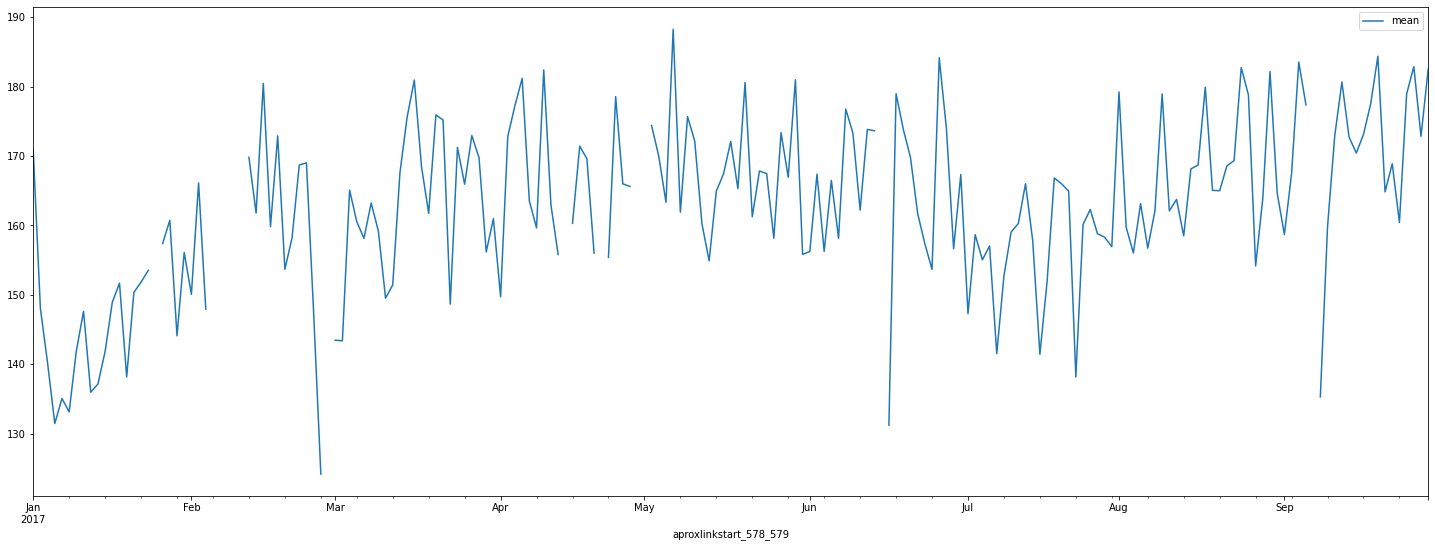

In [ ]:
ltt = ts['ltt'].resample('B').apply([np.mean]).plot(figsize=(25, 9))
# Verificando a média dos dias úteis (B - Bussines) verifica-se que existem falhas, algfuns dados faltantes

## **TRATANDO DADOS AUSENTES**

In [ ]:
all_days = pd.date_range(start='2017-01-02', end='2017-09-29', freq="B")

def get_randon_day(x):
    x_split = x.split("-")
    x_day_plus_5 = abs(random.randint(2, 28))
    x_day_plus_5 = "{0:0=2d}".format(x_day_plus_5)
    new_x = "-".join([x_split[0], x_split[1], str(x_day_plus_5)])
    return new_x

days_empty = []

for row in all_days:
  x = row.strftime("%Y-%m-%d")
  if len(ts.loc['{}'.format(x)]) == 0:
    days_empty.append('{}'.format(x))

print(days_empty)

for i, day in enumerate(days_empty):
  x_plus = get_randon_day(day)
  while len(ts.loc['{}'.format(x_plus)]) == 0:
      x_plus = get_randon_day(day)
  new_ts = ts.loc['{}'.format(x_plus)]
  day_set = day.split("-")
  day_set = day_set[2]
  new_ts.index = new_ts.index.map(lambda t: t.replace(day=int(day_set)))
  new_ts['day'] = '{}'.format(day_set)
  ts = pd.concat([ts, new_ts])

['2017-01-25', '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09', '2017-02-10', '2017-02-28', '2017-04-14', '2017-04-21', '2017-04-28', '2017-05-01', '2017-06-15', '2017-09-07']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



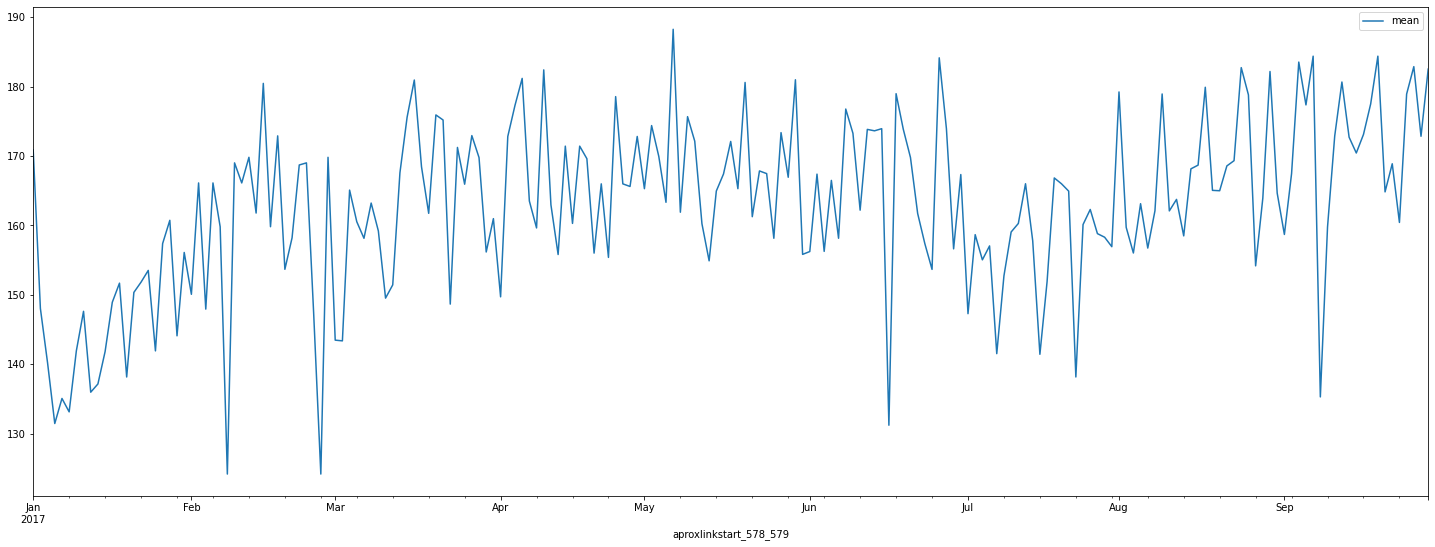

In [ ]:
ltt = ts['ltt'].resample('B').apply([np.mean]).plot(figsize=(25, 9))
# Após o tratamento verifica-se que foram preenchidos os dados que estavam ausentes

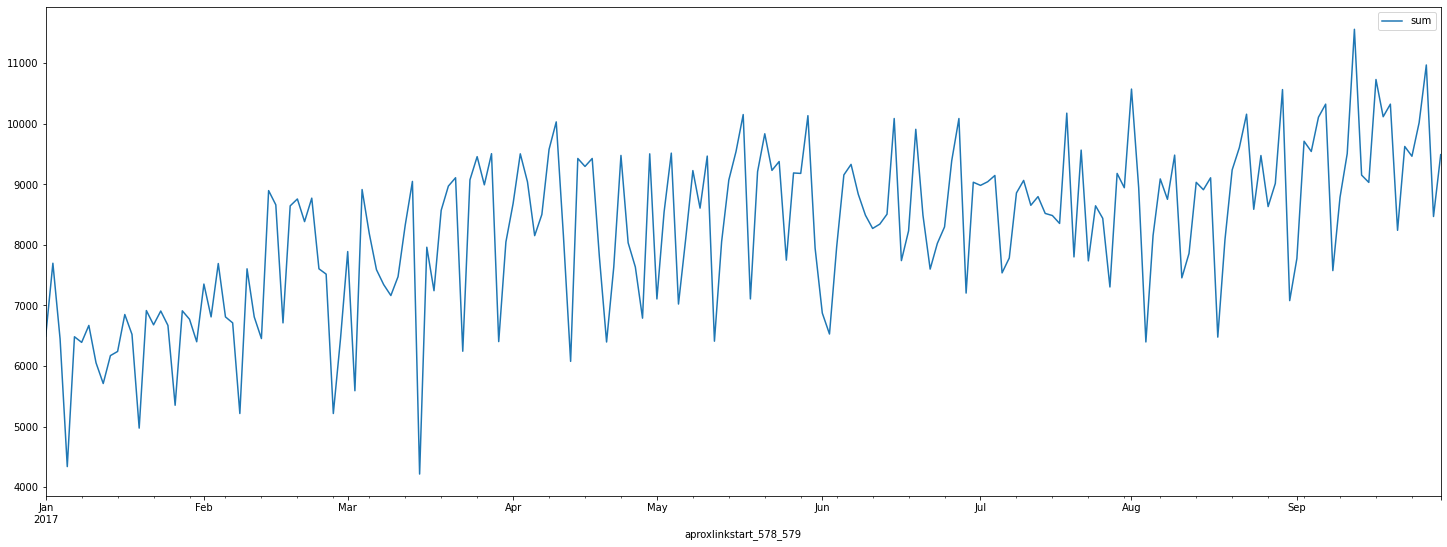

In [ ]:
ltt = ts['ltt'].resample('B').apply([np.sum]).plot(figsize=(25, 9))
# somatório dos dias do mes 01 até o mês 09

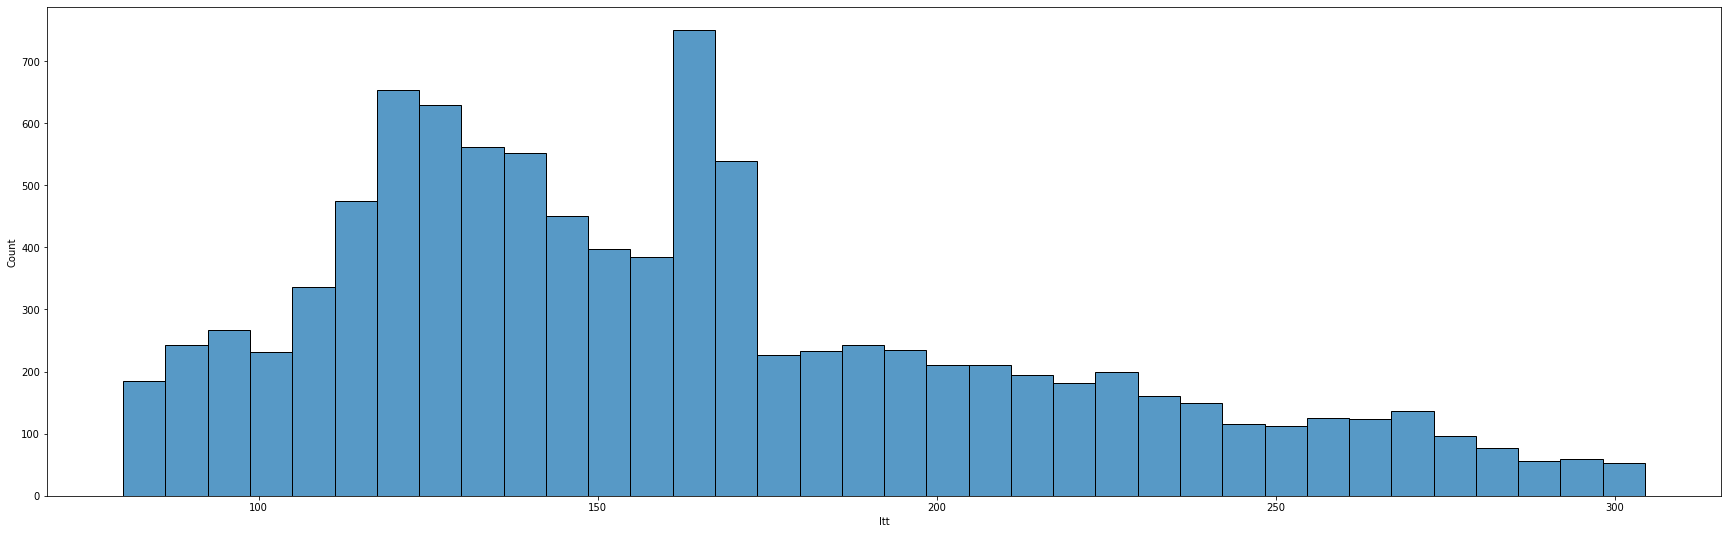

In [ ]:
plt.figure(figsize=(30, 9))
sns.histplot(ts['ltt'])

## **Rede Neural**

In [ ]:
dataset = ts
dataset = dataset.reset_index(drop=True)
dataset = dataset.drop(['day'], axis=1)
dataset = dataset[['ltt','hour','weekday','month']]
dataset

,ltt,hour,weekday,month
0,121.943000,6,2,1
1,292.307000,7,2,1
2,139.832000,7,2,1
3,172.291631,7,2,1
4,172.291631,7,2,1
...,...,...,...,...
9842,153.541000,22,4,9
9843,103.918000,22,4,9
9844,160.338000,23,4,9
9845,166.048000,23,4,9


In [ ]:
dataset['T+1'] = dataset['ltt'].shift()
dataset['T+2'] = dataset['T+1'].shift()
dataset['T+3'] = dataset['T+2'].shift()
dataset['T+4'] = dataset['T+3'].shift()
dataset['T+5'] = dataset['T+4'].shift()
dataset = dataset.fillna(1)
# dataset.isnull()
dataset

,ltt,hour,weekday,month,T+1,T+2,T+3,T+4,T+5
0,121.943000,6,2,1,1.000000,1.000,1.000,1.000,1.000
1,292.307000,7,2,1,121.943000,1.000,1.000,1.000,1.000
2,139.832000,7,2,1,292.307000,121.943,1.000,1.000,1.000
3,172.291631,7,2,1,139.832000,292.307,121.943,1.000,1.000
4,172.291631,7,2,1,172.291631,139.832,292.307,121.943,1.000
...,...,...,...,...,...,...,...,...,...
9842,153.541000,22,4,9,111.651000,117.623,131.806,130.773,139.420
9843,103.918000,22,4,9,153.541000,111.651,117.623,131.806,130.773
9844,160.338000,23,4,9,103.918000,153.541,111.651,117.623,131.806
9845,166.048000,23,4,9,160.338000,103.918,153.541,111.651,117.623


In [ ]:
# separação treino em teste
pct_split = 0.8
train_dataset = dataset.loc[0:7907,:]
train_dataset

,ltt,hour,weekday,month,T+1,T+2,T+3,T+4,T+5
0,121.943000,6,2,1,1.000000,1.000,1.000000,1.000000,1.000000
1,292.307000,7,2,1,121.943000,1.000,1.000000,1.000000,1.000000
2,139.832000,7,2,1,292.307000,121.943,1.000000,1.000000,1.000000
3,172.291631,7,2,1,139.832000,292.307,121.943000,1.000000,1.000000
4,172.291631,7,2,1,172.291631,139.832,292.307000,121.943000,1.000000
...,...,...,...,...,...,...,...,...,...
7903,150.575000,19,6,8,249.828000,260.345,172.291631,172.291631,300.886000
7904,196.869000,19,6,8,150.575000,249.828,260.345000,172.291631,172.291631
7905,89.710000,20,6,8,196.869000,150.575,249.828000,260.345000,172.291631
7906,190.549000,20,6,8,89.710000,196.869,150.575000,249.828000,260.345000


In [ ]:
# retira dos dados totais, a parte de treino
test_dataset = dataset.drop(train_dataset.index)
test_ltt = test_dataset
test_dataset

,ltt,hour,weekday,month,T+1,T+2,T+3,T+4,T+5
7908,126.406,21,6,8,258.776,190.549,89.710,196.869,150.575
7909,124.407,21,6,8,126.406,258.776,190.549,89.710,196.869
7910,124.874,21,6,8,124.407,126.406,258.776,190.549,89.710
7911,146.835,22,6,8,124.874,124.407,126.406,258.776,190.549
7912,168.525,22,6,8,146.835,124.874,124.407,126.406,258.776
...,...,...,...,...,...,...,...,...,...
9842,153.541,22,4,9,111.651,117.623,131.806,130.773,139.420
9843,103.918,22,4,9,153.541,111.651,117.623,131.806,130.773
9844,160.338,23,4,9,103.918,153.541,111.651,117.623,131.806
9845,166.048,23,4,9,160.338,103.918,153.541,111.651,117.623


In [ ]:
test_dataset.columns

Index(['ltt', 'hour', 'weekday', 'month', 'T+1', 'T+2', 'T+3', 'T+4', 'T+5'], dtype='object')

In [ ]:
test_ltt = test_dataset[['ltt']].values
test_ltt

array([[126.406],
       [124.407],
       [124.874],
       ...,
       [160.338],
       [166.048],
       [159.492]])

In [ ]:
train_stats = train_dataset.describe()

# Remoção da variável target
train_stats.pop("ltt")


train_stats = train_stats.T
train_stats

,count,mean,std,min,25%,50%,75%,max
hour,7908.0,13.910597,5.330007,6.0,9.00000,14.0000,19.00000,23.000
weekday,7908.0,3.911608,1.414804,2.0,3.00000,4.0000,5.00000,6.000
month,7908.0,4.693728,2.241017,1.0,3.00000,5.0000,7.00000,8.000
T+1,7908.0,161.672500,50.049065,1.0,123.86225,152.9150,189.44025,304.444
T+2,7908.0,161.648531,50.080613,1.0,123.84300,152.9065,189.39450,304.444
T+3,7908.0,161.637313,50.106657,1.0,123.84300,152.9065,189.39450,304.444
T+4,7908.0,161.612545,50.137640,1.0,123.83675,152.8995,189.35075,304.444
T+5,7908.0,161.593630,50.170008,1.0,123.83450,152.8995,189.35075,304.444


In [ ]:
# Separação e variáveis preditoras (label) a variável target
# variável target: variável que o modelo pretende prever
# variáveis preditoras: variáveis utilizadas como input para o modelo realizar a previsão
    
train_labels = train_dataset.pop('ltt')
test_labels = test_dataset.pop('ltt')

In [ ]:
#função de normalização dados - criando função de normalização
def nomalize(x):
    return (x - train_stats['mean']) / train_stats['std']

In [ ]:
#normalizando dados previsores
normed_train_data = nomalize(train_dataset)
normed_test_data = nomalize(test_dataset)

In [ ]:
def model_one():
    model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[len(train_dataset.keys())], use_bias=True),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', 'mape'])
    return model

In [ ]:
model = model_one()
model

In [ ]:
train_dataset.keys()

Index(['hour', 'weekday', 'month', 'T+1', 'T+2', 'T+3', 'T+4', 'T+5'], dtype='object')

In [ ]:
# Caracteristica da rede neural
# modelo sequencial, com camadas densamente conectadas
# Função de ativação selu (Scaled Exponential Linear Unit) 
# output de um valor numérico, na última camada
# Função de custo Erro Quadrado Médio (Mean Squared Error)
# 300 epocas
# Função do otimização Adam
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                288       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6

In [ ]:
## classe mostra progresso
class Progresso(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: 
      print('')
    print('*', end='')

In [ ]:
#Treinamento do model one
EPOCHS = 300

history = model.fit(
    x=normed_train_data,
    y=train_labels,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
    callbacks=[Progresso()]
)


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************

In [ ]:
history.__dict__.keys()

dict_keys(['validation_data', 'model', '_chief_worker_only', '_supports_tf_logs', 'history', 'params', 'epoch'])

In [ ]:
history.history.keys()

dict_keys(['loss', 'mae', 'mse', 'mape', 'val_loss', 'val_mae', 'val_mse', 'val_mape'])

In [ ]:
historico = pd.DataFrame(history.history)
historico['epoch'] = history.epoch
historico.tail()

,loss,mae,mse,mape,val_loss,val_mae,val_mse,val_mape,epoch
295,399.423248,15.395995,399.423248,10.300756,4092.048096,49.233238,4092.048096,30.846727,295
296,400.027069,15.471846,400.027069,10.383801,4033.614502,48.969833,4033.614502,30.279446,296
297,395.928558,15.237122,395.928558,10.238808,3916.289551,48.394814,3916.289551,30.735592,297
298,400.291260,15.431408,400.291260,10.339651,4049.201660,48.949432,4049.201660,30.738272,298
299,394.475983,15.321007,394.475983,10.253921,4210.892090,49.790340,4210.892090,30.957844,299


In [ ]:
historico.describe()


,loss,mae,mse,mape,val_loss,val_mae,val_mse,val_mape,epoch
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,1021.365001,24.351415,1021.365001,16.199027,3301.589386,44.379109,3301.589386,27.897086,149.500000
std,535.536453,6.341065,535.536453,4.094838,717.129958,4.384451,717.129958,3.083447,86.746758
min,394.475983,15.237122,394.475983,10.238808,1971.203857,35.792023,1971.203857,21.204205,0.000000
25%,589.393173,18.872914,589.393173,12.669661,2709.497620,40.617687,2709.497620,25.561592,74.750000
50%,900.770447,23.455921,900.770447,15.670050,3446.619019,45.268230,3446.619019,28.201859,149.500000
75%,1377.830414,29.431903,1377.830414,19.462635,3918.498535,48.096233,3918.498535,30.367634,224.250000
max,5187.269531,53.592743,5187.269531,33.883537,4791.099121,53.126389,4791.099121,35.884727,299.000000


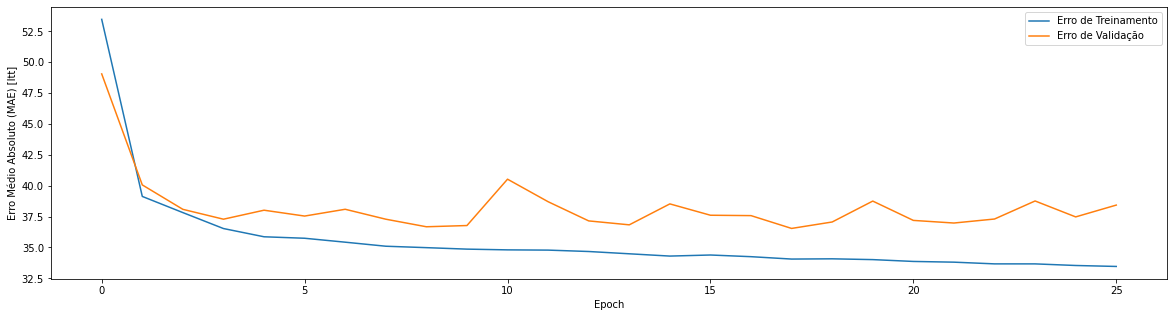

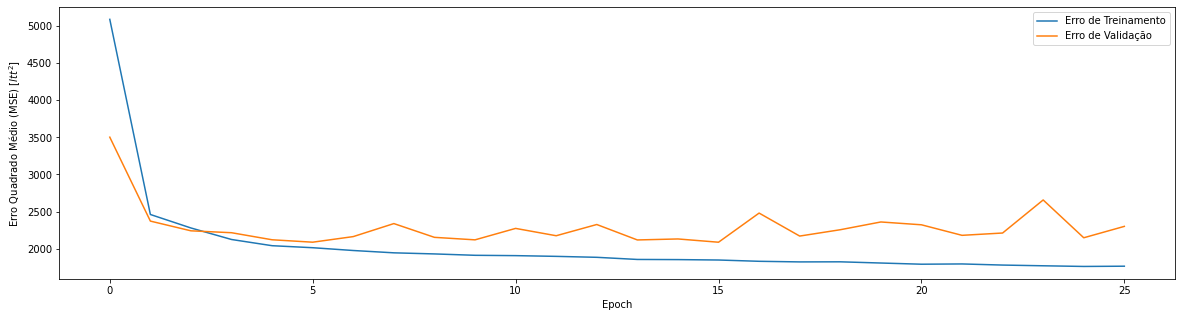

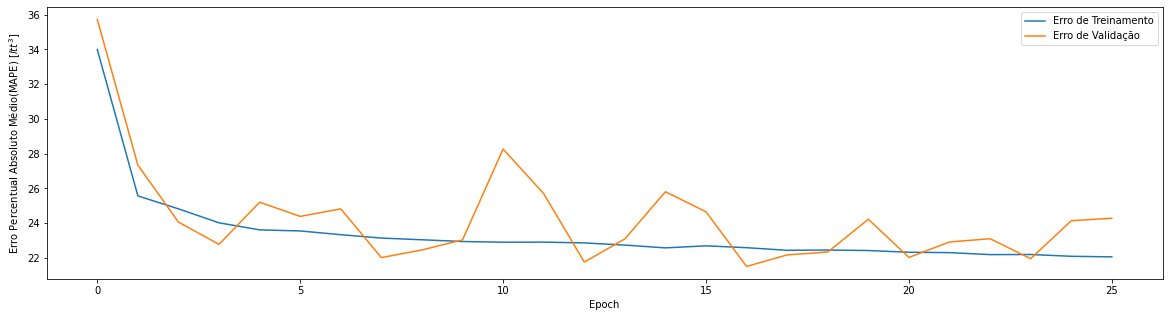

In [ ]:
def plota_historico(history, limita=False):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(20,5))
  plt.xlabel('Epoch')
  plt.ylabel('Erro Médio Absoluto (MAE) [ltt]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Erro de Treinamento')
  plt.legend(loc='best', fontsize=25)
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Erro de Validação')
  plt.legend(loc='best', fontsize=25)
  if limita == True:
    plt.ylim([0,5])
  plt.legend()

  plt.figure(figsize=(20,5))
  plt.xlabel('Epoch')
  plt.ylabel('Erro Quadrado Médio (MSE) [$ltt^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Erro de Treinamento')
  plt.legend(loc='best', fontsize=25)
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Erro de Validação')
  plt.legend(loc='best', fontsize=25)
  if limita == True:
    plt.ylim([0,20])
  plt.legend()

  plt.figure(figsize=(20,5))
  plt.xlabel('Epoch')
  plt.ylabel('Erro Percentual Absoluto Médio(MAPE) [$ltt^3$]')
  plt.plot(hist['epoch'], hist['mape'],
           label='Erro de Treinamento')
  plt.legend(loc='best', fontsize=25)
  plt.plot(hist['epoch'], hist['val_mape'],
           label = 'Erro de Validação')
  plt.legend(loc='best', fontsize=25)
  if limita == True:
    plt.ylim([0,20])
  plt.legend()
  plt.show()


plota_historico(history)


*****************************

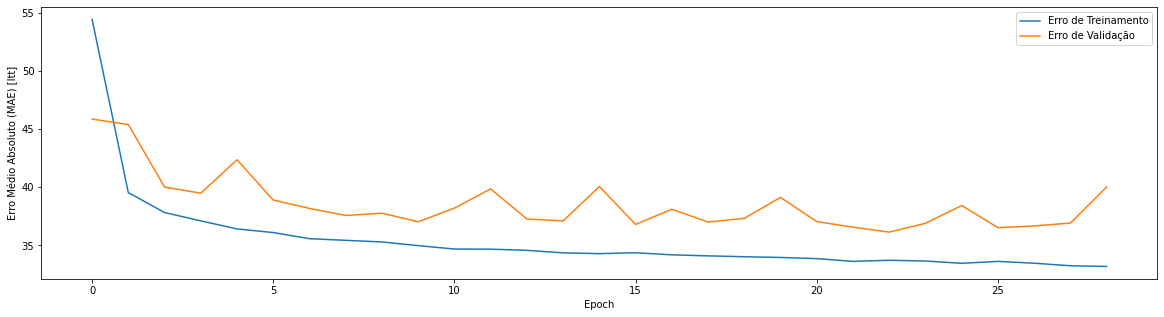

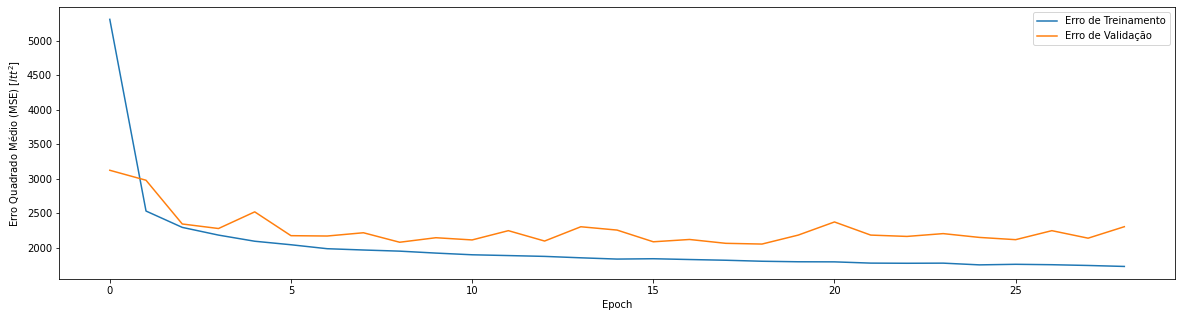

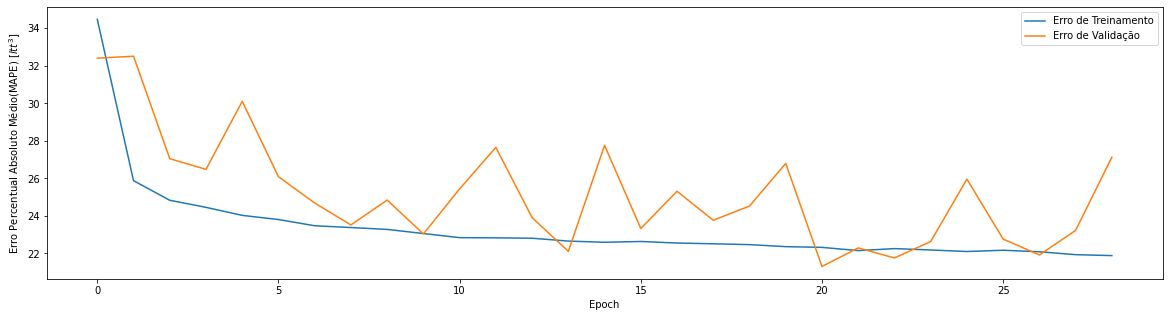

In [ ]:
model = model_one()

# O paramêtro patience é o quantidade de epochs para checar as melhoras
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    normed_train_data, 
    train_labels, 
    epochs=EPOCHS,
    validation_split = 0.2, 
    verbose=0, 
    callbacks=[early_stop, Progresso()])

plota_historico(history)

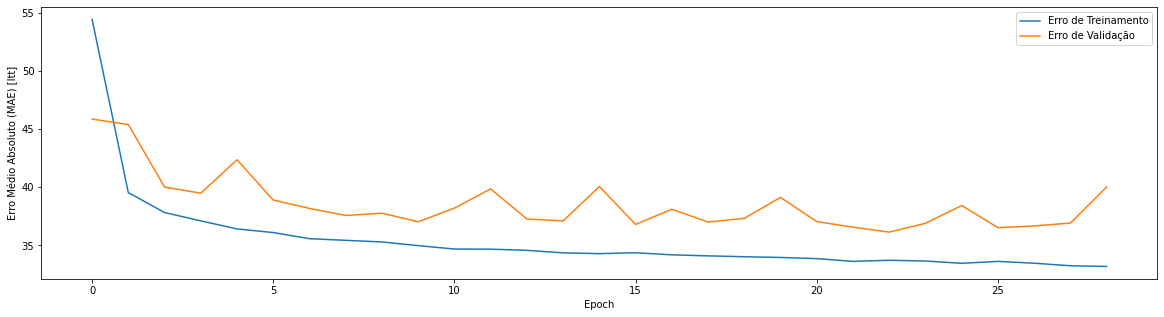

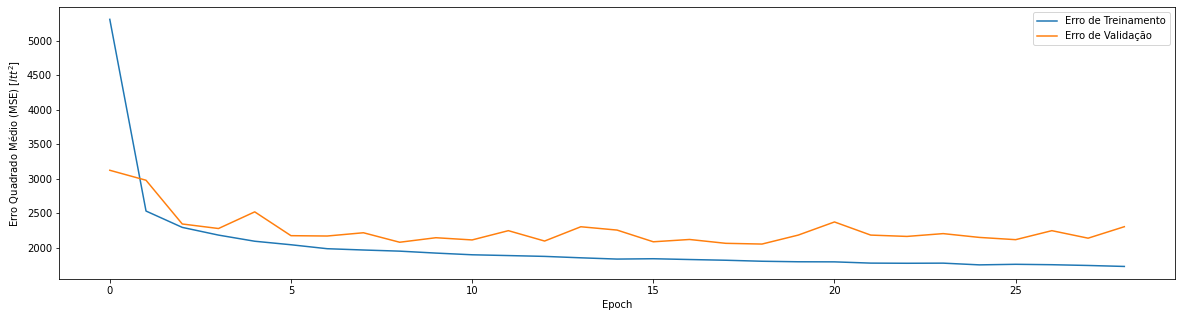

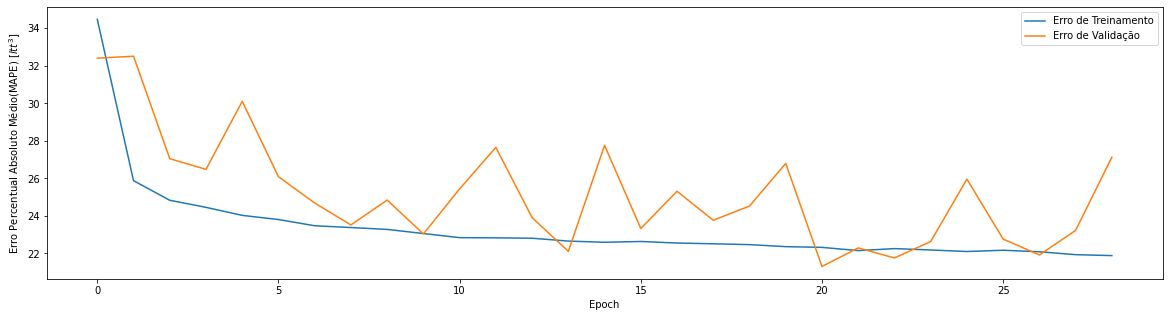

In [ ]:
plota_historico(history)

In [ ]:
loss, mae, mse, mape = model.evaluate(normed_test_data, test_labels, verbose=2)

print(" \n Erro Absoluto Médio calculado nos testes Teste: {:5.2f}\n ".format(mae))

61/61 - 0s - loss: 2402.0767 - mae: 40.1920 - mse: 2402.0767 - mape: 25.8750
 
 Erro Absoluto Médio calculado nos testes Teste: 40.19
 


In [ ]:
train_dataset

,hour,weekday,month,T+1,T+2,T+3,T+4,T+5
0,6,2,1,1.000000,1.000,1.000000,1.000000,1.000000
1,7,2,1,121.943000,1.000,1.000000,1.000000,1.000000
2,7,2,1,292.307000,121.943,1.000000,1.000000,1.000000
3,7,2,1,139.832000,292.307,121.943000,1.000000,1.000000
4,7,2,1,172.291631,139.832,292.307000,121.943000,1.000000
...,...,...,...,...,...,...,...,...
7903,19,6,8,249.828000,260.345,172.291631,172.291631,300.886000
7904,19,6,8,150.575000,249.828,260.345000,172.291631,172.291631
7905,20,6,8,196.869000,150.575,249.828000,260.345000,172.291631
7906,20,6,8,89.710000,196.869,150.575000,249.828000,260.345000


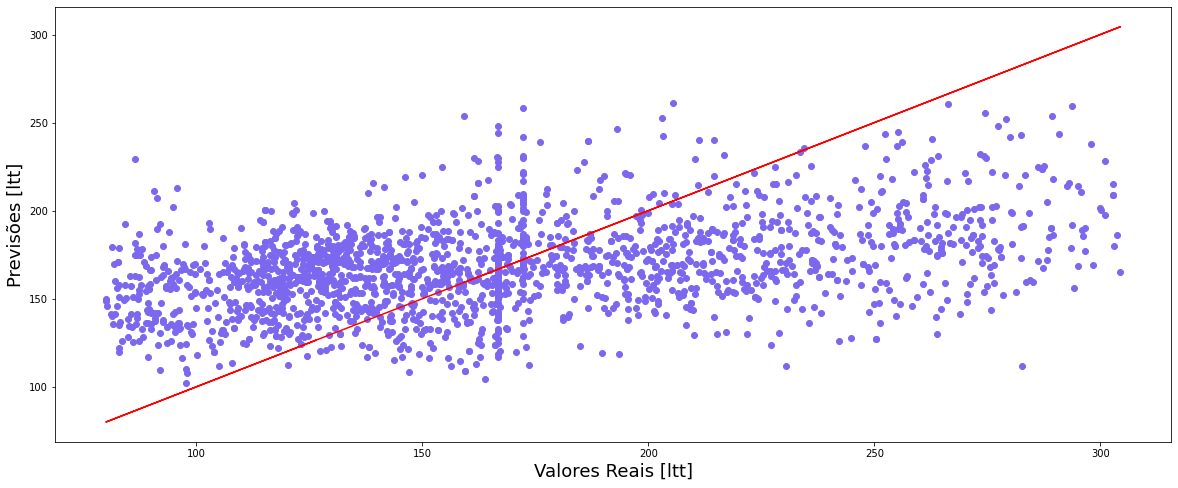

In [ ]:
#Previsões
previsoes_teste = model.predict(normed_test_data).flatten()
plt.figure(figsize=(20,8))
plt.scatter(test_labels, previsoes_teste, color="mediumslateblue")
plt.plot(test_ltt, test_labels, color="red")
plt.xlabel('Valores Reais [ltt]', fontsize=18)
plt.ylabel('Previsões [ltt]', fontsize=18)

plt.show()

In [ ]:
len(previsoes_teste)

1939

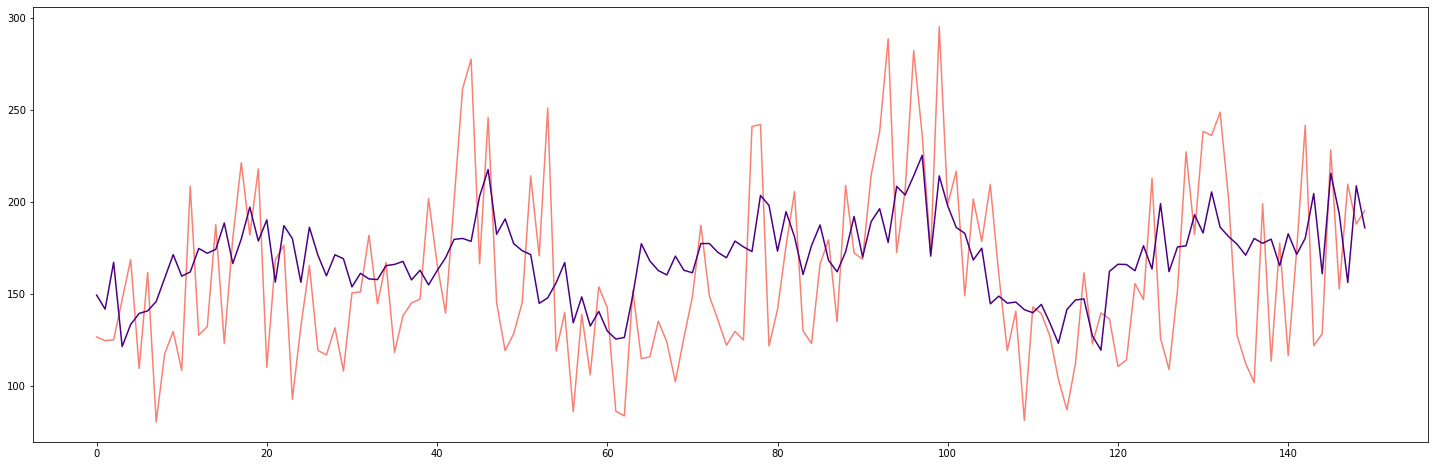

In [ ]:

plt.figure(figsize=(25,8))
plt.plot(test_ltt[0:150], color='salmon')
plt.plot(previsoes_teste[0:150,], color='indigo')
plt.show()


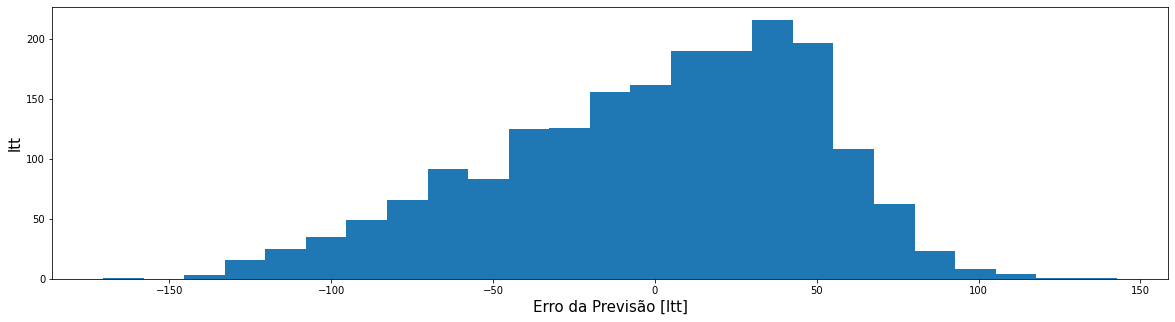

In [ ]:
# Verifica a distribuição dos erros se são de distribuição aproximadamente Gaussiana
plt.figure(figsize=(20,5))
erro = previsoes_teste - test_labels
plt.hist(erro, bins = 25)
plt.xlabel("Erro da Previsão [ltt]", fontsize=15)
_ = plt.ylabel("ltt", fontsize=15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



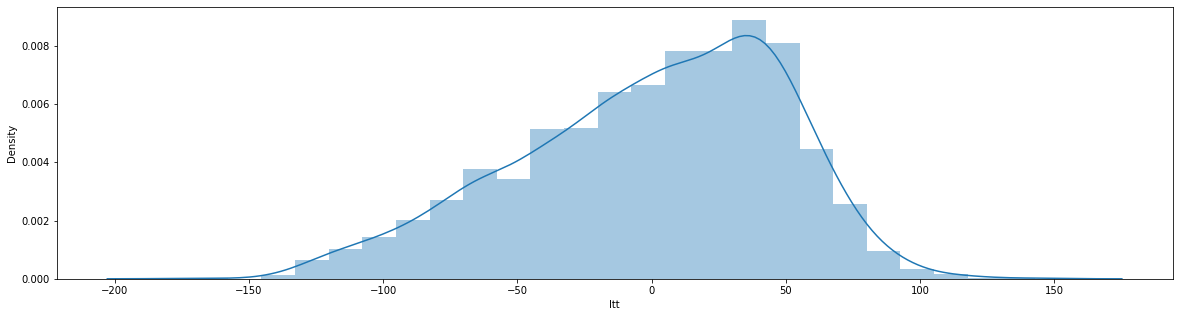

In [ ]:
plt.figure(figsize=(20,5))
sns.distplot(a=erro, bins=25)
plt.show()